In [2]:
from Bio.PDB import PDBParser
import time
import scipy
import time
import scipy.spatial
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt



In [28]:
'''Step 1: Counting n-neighbours for atoms'''

def extract_pdb_info(pdb_file_path):
    """
    Reads a PDB file and extracts 3D spatial coordinates and amino acids.

    Input: pdb_file_path (str): Path to the PDB file.

    Output:  A list of dictionaries, each containing information about each atom.
    """
    # Create a PDBParser object
    parser = PDBParser(PERMISSIVE=1)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure('protein', pdb_file_path)
    
    # List to hold the extracted information
    atom_info_list = []

    # Extract information from the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        'model_id': model.id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': residue.id[1],
                        'atom_name': atom.name,
                        'atom_coords': atom.coord.tolist()
                    }
                    atom_info_list.append(atom_info)

    return atom_info_list

'''Step 2: Counting n-neighbours for amino acids'''

def find_nearest_neighbors(data, angstrom):
    """
    Find the n-neighbors closest to the 'CA' atoms in the data using brute force with Euclidean distance.

    Parameters:
    - data: list of dictionaries, each containing atom information
    - angstrom: float, distance threshold for neighbor counting

    Returns:
    - data: list of dictionaries, containing only 'CA' atoms with updated 'neighbour_count' field,
      and without 'model_id', 'atom_name', and 'atom_coords' keys.
    """
    start_time = time.time()

    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms = [atom for atom in data if atom.get('chain_id') == 'A' and atom['atom_name'] == 'CA']
    ca_coords = np.array([atom['atom_coords'] for atom in ca_atoms])

    # Calculate distances between 'CA' atoms
    distances = scipy.spatial.distance.cdist(ca_coords, ca_coords, 'euclidean')

    # Use 'residue_id' for DataFrame indexing
    residue_ids = [atom.get('residue_id', f"residue_{i}") for i, atom in enumerate(ca_atoms)]
    
    # Convert distance matrix to pandas DataFrame
    distance_df = pd.DataFrame(distances, index=residue_ids, columns=residue_ids)

    # Format distance matrix to 3 decimal places
    distance_df = distance_df.round(3)

    # Print the distance matrix
    print("Distance matrix between CA atoms (formatted to 3 decimal places):")
    print(distance_df)

    # Count neighbors within a distance of 'angstrom' units for each 'CA' atom
    for index, ca_point in enumerate(ca_coords):
        neighbour_count = np.sum((distances[index] <= angstrom) & (distances[index] != 0))
        ca_atoms[index]['neighbour_count'] = neighbour_count

    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    for atom in ca_atoms:
        for key in keys_to_remove:
            atom.pop(key, None)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Elapsed time: {elapsed:.2f} seconds")

    return ca_atoms

def extract_conservation_score(filename):
    result = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                # Skip header lines and lines below confidence cut-off
                if re.match(r'\s*\d+', line):
                    columns = line.split()
                    pos = int(columns[0])
                    score = float(columns[3])

                    # Check if there is a 3LATOM value, otherwise continue
                    if len(columns) > 6 and ':' in columns[2]:
                        residue_id = re.findall(r'\d+', columns[2])[0]  # Extract numbers from the string
                        residue_id = int(residue_id)  # Convert extracted string to integer
                        residue_name = re.findall(r'[A-Za-z]+', columns[2])[0]  # Extract letters from the string
                        result.append({'residue_id': residue_id, 'residue_name': residue_name, 'conservation_score': score})

        return result
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None

def merge_residue_data(conservation_scores, neighbour_counts):
    # Create a dictionary to index the neighbour_counts by residue_id and residue_name
    neighbour_dict = {(item['residue_id'], item['residue_name']): item for item in neighbour_counts}
    
    # List to hold merged data
    merged_data = []
    
    # Merge data from conservation_scores with neighbour_counts
    for score_entry in conservation_scores:
        residue_id = score_entry['residue_id']
        residue_name = score_entry['residue_name']
        
        # Find the corresponding entry in neighbour_counts
        neighbour_entry = neighbour_dict.get((residue_id, residue_name))
        
        if neighbour_entry:
            # Merge the two entries
            merged_entry = {
                'residue_id': residue_id,
                'residue_name': residue_name,
                'conservation_score': score_entry['conservation_score'],
                'neighbour_count': neighbour_entry['neighbour_count']
            }
            merged_data.append(merged_entry)
    
    return merged_data

def plot_and_calculate_correlation(data, title, angstrom):
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    neighbour_counts = [entry['neighbour_count'] for entry in data]
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot neighbour counts
    plt.scatter(residue_ids, neighbour_counts, color='green', label='Neighbour Count')
    
    # Check and plot conservation scores if available
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    if conservation_scores:
        valid_entries = [entry for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
        valid_residue_ids = [entry['residue_id'] for entry in valid_entries]
        valid_neighbour_counts = [entry['neighbour_count'] for entry in valid_entries]
        
        plt.scatter(valid_residue_ids, conservation_scores, color='blue', label='Conservation Score')
        
        # Calculate and print the correlation
        if len(valid_residue_ids) == len(conservation_scores):
            correlation = np.corrcoef(conservation_scores, valid_neighbour_counts)[0, 1]
            print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")
        else:
            print("Mismatch in lengths of valid_residue_ids and conservation_scores")
    else:
        print("Conservation scores not found. Plotting only Neighbour Count.")
    
    plt.xlabel('Residue ID')
    plt.ylabel('Score / Count')
    plt.title(f'{title}: Residue ID vs Conservation Score and Neighbour Count ({angstrom}A)')
    plt.legend()
    
    # Set plot limits for residue IDs
    plt.xlim(0, 1600)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [29]:
def pdb_to_n_neighbour_vector(pdb_file_path, angstrom):
    '''Step 1: Counting n-neighbours for atoms'''
    # convert_cif_to_pdb(cif_file_path, pdb_file_path)
    amino_vector = []
    title = pdb_file_path.split('/')[-1].split('.')[0][3:].upper()

    atom_info_list = extract_pdb_info(pdb_file_path)

    amino_acid_info_count = find_nearest_neighbors(atom_info_list, angstrom)

    print(f"Number of Amino Acids: {len(amino_acid_info_count)}")
    conservation_scores = extract_conservation_score(filename=f"conservation_scores/{title}_consurf_summary.txt")
    print(conservation_scores)

    if conservation_scores is not None:
        merged_residues = merge_residue_data(conservation_scores, amino_acid_info_count)
        print(merged_residues)
        plot_and_calculate_correlation(merged_residues, title, angstrom)
    else:
        print("Conservation scores not found, skipping merge_residue_data. Going straight to plotting.")
        merged_residues = amino_acid_info_count
        plot_and_calculate_correlation(merged_residues, title, angstrom)

    return merged_residues

def merge_to_ref_seq(ref_seq, completed):
    # Convert ref_seq to dictionary for efficient lookup
    ref_seq_dict = {entry['residue_id']: entry for entry in ref_seq}

    for entry in completed:
        residue_id = entry['residue_id']
        if residue_id in ref_seq_dict:
            ref_seq_entry = ref_seq_dict[residue_id]
            if 'neighbour_count' in entry:
                ref_seq_entry['neighbour_count'] = max(ref_seq_entry['neighbour_count'], entry['neighbour_count'])
            if 'conservation_score' in entry:
                ref_seq_entry['conservation_score'] = entry['conservation_score']
        else:
            ref_seq_dict[residue_id] = {
                'residue_id': residue_id,
                'residue_name': entry['residue_name'],
                'neighbour_count': entry.get('neighbour_count', 0),
                'conservation_score': entry.get('conservation_score')
            }

    # Convert back to list
    updated_ref_seq = list(ref_seq_dict.values())
    return updated_ref_seq



Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9     \
1      0.000   3.752   7.576  10.522  13.273  16.894  19.129  21.499  24.692   
2      3.752   0.000   3.904   6.805   9.644  13.326  15.789  18.440  21.658   
3      7.576   3.904   0.000   3.162   6.654  10.276  13.285  16.315  19.414   
4     10.522   6.805   3.162   0.000   3.868   7.249  10.537  13.714  16.695   
5     13.273   9.644   6.654   3.868   0.000   3.824   6.733  10.086  13.228   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1612  62.208  63.840  65.067  66.213  68.513  69.595  71.713  71.629  71.820   
1613  62.779  64.225  65.235  66.259  68.548  69.500  71.692  71.630  71.708   
1614  60.155  61.655  62.693  63.814  66.244  67.332  69.658  69.776  70.004   
1615  62.166  63.839  65.040  66.298  68.821  70.058  72.410  72.600  72.952   
1616  65.505  67.072  68.151  69.316  71.791  72.911  

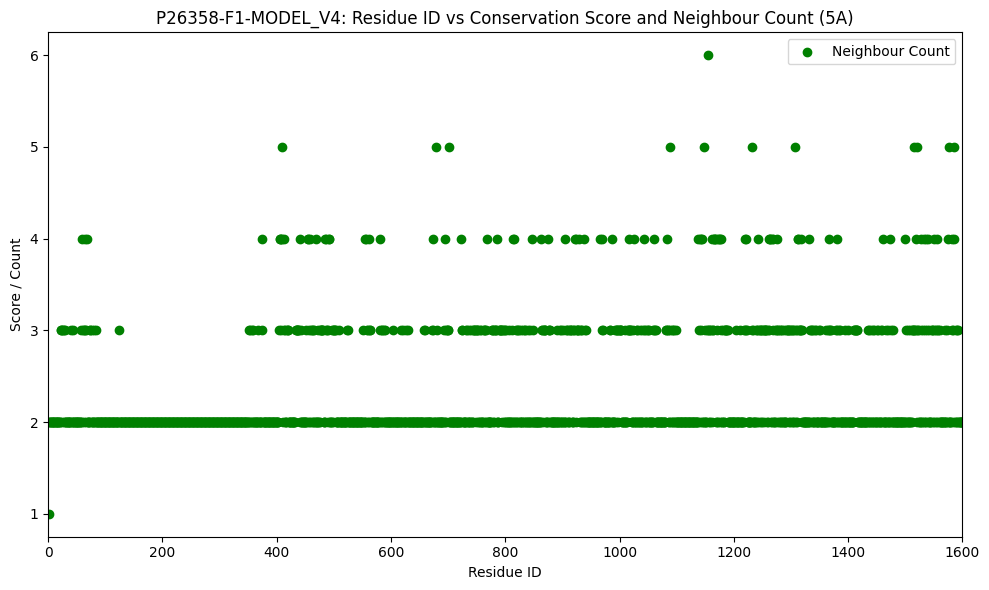

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8012.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8032.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8033.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8100.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        350     351     352     353     354     355     356     357     358  \
350   0.000   3.840   6.619  10.080  12.522  15.215  14.354  11.191   9.861   
351   3.840   0.000   3.830   6.922   9.073  12.052  11.932   9.120   8.552   
352   6.619   3.830   0.000   3.763   6.111   8.610   8.144   5.349   5.365   
353  10.080   6.922   3.763   0.000   3.808   5.403   5.764   4.870   5.411   
354  12.522   9.073   6.111   3.808   0.000   3.828   6.070   5.686   8.163   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
595  43.599  43.543  40.458  40.392  39.908  38.055  35.391  35.675  36.728   
596  44.233  44.399  41.383  41.379  41.230  39.324  36.417  36.695  37.373   
597  47.622  47.837  44.868  44.940  44.696  42.862  40.017  40.215  40.980   
598  48.583  48.505  45.355  45.131  44.681  42.631  39.976  40.487  41.437   
599  47.596  47.530  44.331  43.974  43.758  41.522  38.734  39.4

TypeError: plot_and_calculate_correlation() missing 1 required positional argument: 'angstrom'

In [32]:
pdb_file_path = ['./pdb/pdb3epz.pdb', './pdb/pdb3pta.pdb', './pdb/pdb3swr.pdb', './pdb/pdb4wxx.pdb',
                 './pdb/pdb4yoc.pdb', './pdb/pdb4z96.pdb', './pdb/pdb4z97.pdb', './pdb/pdb5wvo.pdb',
                 './pdb/pdb5ydr.pdb', './pdb/pdb6k3a.pdb', './pdb/pdb6l1f.pdb', './pdb/pdb6x9i.pdb',
                 './pdb/pdb6x9j.pdb', './pdb/pdb6x9k.pdb', './pdb/pdb7sfc.pdb', './pdb/pdb7sfe.pdb',
                 './pdb/pdb7sff.pdb', './pdb/pdb7sfg.pdb']

# './pdb/pdb8v9u.pdb' excluded

ref_seq = './pdb/AF-P26358-F1-model_v4.pdb'
ref_seq = pdb_to_n_neighbour_vector(ref_seq, angstrom = 5)

for pdb_file in pdb_file_path:
        completed = pdb_to_n_neighbour_vector(pdb_file, angstrom = 5)
        ref_seq = merge_to_ref_seq(ref_seq, completed)

[{'chain_id': 'A', 'residue_name': 'MET', 'residue_id': 1, 'neighbour_count': 2, 'conservation_score': -0.816}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 2, 'neighbour_count': 3, 'conservation_score': -0.184}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 3, 'neighbour_count': 3, 'conservation_score': -0.879}, {'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 4, 'neighbour_count': 4, 'conservation_score': 0.583}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 5, 'neighbour_count': 4, 'conservation_score': -1.033}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 6, 'neighbour_count': 4, 'conservation_score': -0.642}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 7, 'neighbour_count': 3, 'conservation_score': -0.406}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 8, 'neighbour_count': 2, 'conservation_score': 1.429}, {'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 9, 'neighbour_count': 2, 'conservation_score': 0.265}, {'c

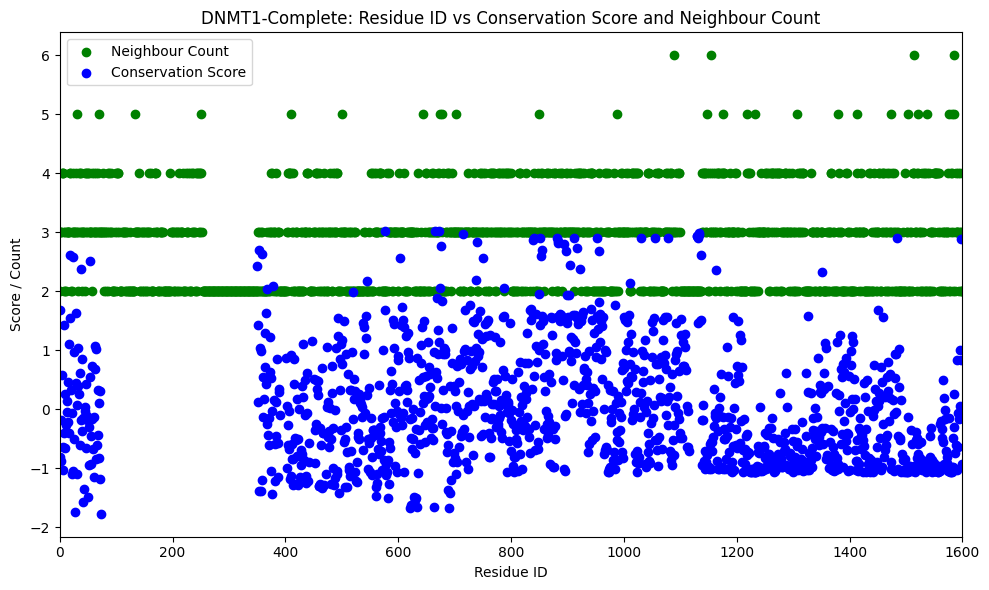

In [27]:
print(ref_seq)
plot_and_calculate_correlation(ref_seq, title='DNMT1-Complete')